# Notebook para probar un modelo Deep Learning LSMT

In [ ]:

!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Wed Nov 30 17:14:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Pasos previos a la generación del modelo

Cargamos el dataset y lo dividimos en sinceras e insinceras

In [ ]:
import pandas as pd
import re
#Cargo el dataset de ejemplo
total_questionsdf = pd.read_csv('train.csv')
#print(total_questionsdf.head())
print (total_questionsdf.shape)

insincere_questionsdf=total_questionsdf.loc[total_questionsdf['target'] == 1]
#print(insincere_questionsdf.head())
print (insincere_questionsdf.shape)
total_questionsdf.head()

sincere_questionsdf=total_questionsdf.loc[total_questionsdf['target'] == 0].sample(len(insincere_questionsdf))
#print(sincere_questionsdf.head())
print (sincere_questionsdf.shape)

(1306122, 3)
(80810, 3)
(80810, 3)


Cargamos el Modelo de Glove para tener pesos más finos y poder probar cómo impacta tener vectores aleatorios o entrenados

In [ ]:
import numpy as np
from numpy import array
# Podemos cargar el fichero glove desde Google Drive
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
%cd /content/drive/My Drive/
print (f"Current working directory: {Path.cwd()}")


embeddings_index = {}
f = open('glove.42B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print(len(embeddings_index))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
Current working directory: /content/drive/My Drive
1917494


Generamos un dataset equilibrado y hacemos un breve preprocesado del texto

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn import metrics
from nltk import pos_tag, word_tokenize
muestraInsinceras=insincere_questionsdf.sample(40000)
muestraSinceras=sincere_questionsdf.sample(40000)

questions=muestraInsinceras['question_text'].append(muestraSinceras['question_text']).tolist()
tags = muestraInsinceras['target'].append(muestraSinceras['target']).tolist()

data = []
data_labels = []

for i in range(len(questions)): 
    questions[i]=questions[i].lower()
    questions[i]=re.sub('[^a-zA-Z\']', ' ', questions[i])
    data.append(questions[i]) 
    data_labels.append(tags[i])




Tokenizamos las frases y construimos la matriz de embeddings

In [ ]:
import numpy as np
from numpy import array
from keras.preprocessing.text import Tokenizer

#función que tokeniza un conjunto de frases
def tokenization(sentences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer

tokenizerTrain = tokenization(questions)

embedding_matrix = np.zeros((len(tokenizerTrain.word_index) + 1, 300))
for word, i in tokenizerTrain.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

from keras.layers import Embedding
embedding_vec_length=300
max_text_length=10
embedding_layer = Embedding(len(tokenizerTrain.word_index) + 1,
                            embedding_vec_length,
                            weights=[embedding_matrix],
                            input_length=max_text_length,
                            trainable=False,
                            mask_zero=True)


{'the': 1, 'to': 2, 'is': 3, 'a': 4, 'in': 5, 'of': 6, 'why': 7, 'and': 8, 'do': 9, 'what': 10, 'are': 11, 'i': 12, 'how': 13, 'for': 14, 'that': 15, 'it': 16, 'you': 17, 'can': 18, 'people': 19, 'with': 20, 'have': 21, 'they': 22, 'be': 23, 'if': 24, 'on': 25, 'or': 26, 'my': 27, 'so': 28, 'does': 29, 'as': 30, 'their': 31, 'when': 32, 'not': 33, 'from': 34, 'like': 35, 'who': 36, 'an': 37, 'should': 38, 'would': 39, 'about': 40, 'will': 41, 'by': 42, 'get': 43, 'there': 44, 'your': 45, 'trump': 46, 'did': 47, 'women': 48, 'was': 49, 'all': 50, 'at': 51, 'we': 52, 'some': 53, 'which': 54, 'this': 55, 'think': 56, 'more': 57, 'has': 58, 'than': 59, 'india': 60, 'but': 61, 'many': 62, 'me': 63, 'most': 64, 'them': 65, 'best': 66, 'any': 67, 'he': 68, 'men': 69, 'quora': 70, 'other': 71, "don't": 72, 'white': 73, 'just': 74, 'one': 75, 'good': 76, 'us': 77, 'indian': 78, 'being': 79, 'make': 80, 'his': 81, 'muslims': 82, 'want': 83, 's': 84, 'after': 85, 'much': 86, 'world': 87, 'out': 8

Utilizamos onehotenconder para los valores de las etiquetas

In [ ]:
import numpy as np
from numpy import array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

values = array(data_labels)
print(values)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)



[1 1 1 ... 0 0 0]
[1 1 1 ... 0 0 0]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


Se divide el conjunto

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(data, onehot_encoded, test_size=0.2, random_state=12) 


## Pasos para usar el modelo LSMT

Codificación de las frases

In [ ]:
def encode_sequences(tokenizer, length, lines):
    # Codificar las secuencias con los índices de las palabras
    seq = tokenizer.texts_to_sequences(lines)
    # Hacer el padding
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq
    
embedding_vec_length=300
max_text_length=10
trainXEncoded = encode_sequences(tokenizerTrain, max_text_length, X_train)

testXEncoded = encode_sequences(tokenizerTrain, max_text_length, X_test)

print(trainXEncoded)

[[  375   144  5883 ...    34     1   978]
 [   91  1538    34 ...  2085   650    72]
 [ 2688    35    22 ...     1 20369  5430]
 ...
 [    3   885     5 ...     6    82     0]
 [    3  8097 27444 ...     0     0     0]
 [   20    37   417 ...    20    45  1389]]


Creación del modelo.
Se presenta con el encoding sin entrenar.

Si se desea probar con Glove, basta con seguir los pasos que se indican

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
import tensorflow as tf

# La siguiente función define el modelo.
# En función de la ejecución que se quiera realizar se puede utilizar para
# la capa de embedding se puede comentar o comentar una línea u otra
# capa_embedding es la variable que contiene el fichero de Glove precargado

def define_model(units, dim_salida):
    mt_model = Sequential()
    vocSize=len(tokenizerTrain.word_index)+1
    #modelo Glove
    #mt_model.add(embedding_layer) 

    #modelo estándar. Comentar la línea de abajo y descomentar la superior para usar el embedding de Glove
    mt_model.add(Embedding(vocSize, embedding_vec_length, input_length = max_text_length, mask_zero=True))
    mt_model.add(LSTM(units))
    mt_model.add(Dense(2, activation='softmax'))
    return mt_model

mt_modelLSTMGlove = define_model(300, 2)


Visualización del modelo

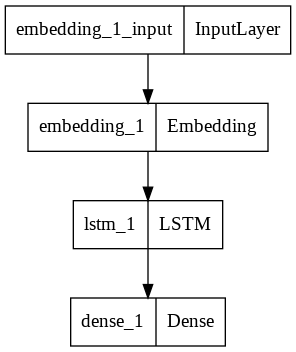

In [ ]:
from tensorflow import optimizers

rms = optimizers.Adam(learning_rate=0.001)
mt_modelLSTMGlove.compile(optimizer=rms, loss='categorical_crossentropy')
tf.keras.utils.plot_model(mt_modelLSTMGlove)

Entrenamiento del modelo anterior

In [ ]:
from keras.callbacks import ModelCheckpoint
filename = 'model_clasif' #Fichero donde guardaremos el modelo para hacer las posteriores predicciones

#La función ModelCheckpoint() guarda el modelo 

checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=False, mode='min')

#Entrenamiento del modelo. Se realiza con 30 epoch con un tamaño de batch de 512

mt_modelLSTMGlove.fit(trainXEncoded, y_train, epochs=30, batch_size=512, callbacks=[checkpoint], verbose=1)

Epoch 1/30
124/125 [============================>.] - ETA: 0s - loss: 0.4272
Epoch 1: saving model to model_clasif


125/125 [==============================] - 16s 106ms/step - loss: 0.4269
Epoch 2/30
123/125 [============================>.] - ETA: 0s - loss: 0.2911
Epoch 2: saving model to model_clasif


125/125 [==============================] - 14s 110ms/step - loss: 0.2912
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 0.2296
Epoch 3: saving model to model_clasif


125/125 [==============================] - 14s 112ms/step - loss: 0.2296
Epoch 4/30
123/125 [============================>.] - ETA: 0s - loss: 0.1828
Epoch 4: saving model to model_clasif


125/125 [==============================] - 13s 107ms/step - loss: 0.1830
Epoch 5/30
123/125 [============================>.] - ETA: 0s - loss: 0.1466
Epoch 5: saving model to model_clasif


125/125 [==============================] - 14s 112ms/step - loss: 0.1466
Epoch 6/30
124/125 [============================>.] - ETA: 0s - loss: 0.1153
Epoch 6: saving model to model_clasif


125/125 [==============================] - 13s 109ms/step - loss: 0.1158
Epoch 7/30
123/125 [============================>.] - ETA: 0s - loss: 0.0936
Epoch 7: saving model to model_clasif


125/125 [==============================] - 14s 109ms/step - loss: 0.0940
Epoch 8/30
125/125 [==============================] - ETA: 0s - loss: 0.0792
Epoch 8: saving model to model_clasif


125/125 [==============================] - 14s 113ms/step - loss: 0.0792
Epoch 9/30
125/125 [==============================] - ETA: 0s - loss: 0.0682
Epoch 9: saving model to model_clasif


125/125 [==============================] - 14s 109ms/step - loss: 0.0682
Epoch 10/30
124/125 [============================>.] - ETA: 0s - loss: 0.0600
Epoch 10: saving model to model_clasif


125/125 [==============================] - 13s 104ms/step - loss: 0.0601
Epoch 11/30
124/125 [============================>.] - ETA: 0s - loss: 0.0468
Epoch 11: saving model to model_clasif


125/125 [==============================] - 14s 115ms/step - loss: 0.0469
Epoch 12/30
124/125 [============================>.] - ETA: 0s - loss: 0.0391
Epoch 12: saving model to model_clasif


125/125 [==============================] - 14s 109ms/step - loss: 0.0392
Epoch 13/30
125/125 [==============================] - ETA: 0s - loss: 0.0310
Epoch 13: saving model to model_clasif


125/125 [==============================] - 14s 109ms/step - loss: 0.0310
Epoch 14/30
125/125 [==============================] - ETA: 0s - loss: 0.0248
Epoch 14: saving model to model_clasif


125/125 [==============================] - 14s 111ms/step - loss: 0.0248
Epoch 15/30
125/125 [==============================] - ETA: 0s - loss: 0.0215
Epoch 15: saving model to model_clasif


125/125 [==============================] - 13s 103ms/step - loss: 0.0215
Epoch 16/30
125/125 [==============================] - ETA: 0s - loss: 0.0189
Epoch 16: saving model to model_clasif


125/125 [==============================] - 14s 112ms/step - loss: 0.0189
Epoch 17/30
123/125 [============================>.] - ETA: 0s - loss: 0.0188
Epoch 17: saving model to model_clasif


125/125 [==============================] - 13s 108ms/step - loss: 0.0189
Epoch 18/30
125/125 [==============================] - ETA: 0s - loss: 0.0156
Epoch 18: saving model to model_clasif


125/125 [==============================] - 14s 110ms/step - loss: 0.0156
Epoch 19/30
123/125 [============================>.] - ETA: 0s - loss: 0.0106
Epoch 19: saving model to model_clasif


125/125 [==============================] - 13s 108ms/step - loss: 0.0106
Epoch 20/30
123/125 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 20: saving model to model_clasif


125/125 [==============================] - 14s 109ms/step - loss: 0.0082
Epoch 21/30
125/125 [==============================] - ETA: 0s - loss: 0.0083
Epoch 21: saving model to model_clasif


125/125 [==============================] - 13s 103ms/step - loss: 0.0083
Epoch 22/30
123/125 [============================>.] - ETA: 0s - loss: 0.0089
Epoch 22: saving model to model_clasif


125/125 [==============================] - 14s 113ms/step - loss: 0.0090
Epoch 23/30
124/125 [============================>.] - ETA: 0s - loss: 0.0086
Epoch 23: saving model to model_clasif


125/125 [==============================] - 14s 109ms/step - loss: 0.0088
Epoch 24/30
124/125 [============================>.] - ETA: 0s - loss: 0.0103
Epoch 24: saving model to model_clasif


125/125 [==============================] - 14s 111ms/step - loss: 0.0102
Epoch 25/30
123/125 [============================>.] - ETA: 0s - loss: 0.0076
Epoch 25: saving model to model_clasif


125/125 [==============================] - 14s 110ms/step - loss: 0.0076
Epoch 26/30
125/125 [==============================] - ETA: 0s - loss: 0.0087
Epoch 26: saving model to model_clasif


125/125 [==============================] - 14s 109ms/step - loss: 0.0087
Epoch 27/30
123/125 [============================>.] - ETA: 0s - loss: 0.0056
Epoch 27: saving model to model_clasif


125/125 [==============================] - 14s 111ms/step - loss: 0.0056
Epoch 28/30
124/125 [============================>.] - ETA: 0s - loss: 0.0030
Epoch 28: saving model to model_clasif


125/125 [==============================] - 14s 110ms/step - loss: 0.0030
Epoch 29/30
125/125 [==============================] - ETA: 0s - loss: 0.0023
Epoch 29: saving model to model_clasif


125/125 [==============================] - 14s 110ms/step - loss: 0.0023
Epoch 30/30
124/125 [============================>.] - ETA: 0s - loss: 0.0039
Epoch 30: saving model to model_clasif


125/125 [==============================] - 14s 109ms/step - loss: 0.0038


Carga del modelo y realización de la predicción

In [ ]:
from keras.models import load_model

#Cargo el modelo y realizo las predicciones
modelClasificador = load_model('model_clasif')
preds = modelClasificador.predict(testXEncoded)
#Convierto las predicciones a números enteros para poder comparar con el conjunto de test
predsInt=np.rint(preds)

500/500 [==============================] - 2s 3ms/step


In [ ]:
from sklearn.metrics import accuracy_score
#Calculo el porcentaje de aciertos ayudándome de accuracy_score de sklearn

resultado=accuracy_score(y_test, predsInt)
print("El porcentaje de acierto en la clasificación es ", resultado)
rm = metrics.classification_report(y_test, predsInt, target_names=['SINCERE', 'INSINCERE'])

print(rm)

El porcentaje de acierto en la clasificación es  0.781125
              precision    recall  f1-score   support

     SINCERE       0.79      0.78      0.78      8072
   INSINCERE       0.78      0.78      0.78      7928

   micro avg       0.78      0.78      0.78     16000
   macro avg       0.78      0.78      0.78     16000
weighted avg       0.78      0.78      0.78     16000
 samples avg       0.78      0.78      0.78     16000

